In [1]:
# Задание 2
# Загрузите данные результата A/B-теста по кейсу Яндекс Такси. 
# Таргет в этой задаче — факт использования тарифа Комфорт.

import pandas as pd

data = pd.read_csv("ab_results.csv")
data.head()

,usage_duration,number_of_bank_cards,money_spent_amount,visit_frequency,number_of_visited_shops,number_of_viewed_communications,age,treatment,target
0,4.675074,1,463182.628027,6.782820,4,58,65.529513,0,0
1,4.315465,1,379881.205811,6.947705,3,81,41.285985,1,0
2,5.135106,1,528345.551898,8.665648,7,89,39.280205,1,1
3,4.357843,1,568219.437346,5.002878,3,46,47.544483,1,0
4,4.518232,1,340441.730023,6.979684,5,58,56.911754,0,0


In [2]:
# Задание 3 
# Для начала подготовьте данные. 
# Разделите выборку на обучающую и тестовую, используя стратификацию по столбцам target и treatment,
#  — так вы обеспечите равномерное распределение классов в обеих выборках. 
# Это поможет избежать смещения в модели и улучшить её способность к обобщению на новых данных. 

import numpy as np
from sklearn.model_selection import train_test_split


# разделим данные на признаки и целевую переменную
X = data.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = data['target']  # целевая переменная (например, количество поездок)

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=data[['target', 'treatment']],
                                    random_state=42)
        


In [ ]:
# Задание 4 
# Чтобы обучить S-learner, создайте экземпляр модели RandomForestClassifier, 
# настройте его параметры и обучите на обучающей выборке. 
# После этого вы сможете использовать модель, 
# чтобы предсказывать вероятность отклика на скидку как пользователей с воздействием, так и без него. 
# При этом вы будете использовать фичу treatment как изменяющийся параметр.



from sklearn.ensemble import RandomForestClassifier
# обучим модель RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=6,       
    random_state=42,  
    verbose=1         
)

model.fit(X_train, y_train)

# чтобы оценить uplift-эффекта для каждого пользователя:
# 1. Создаём копию тестовых данных
X_test_treated = X_test.copy()
X_test_control = X_test.copy()

# 2. Устанавливаем значение признака treatment
X_test_treated['treatment'] = 1  # С воздействием
X_test_control['treatment'] = 0  # Без воздействия

# 3. Предсказываем результаты для обоих случаев
y_pred_treated = model.predict_proba(X_test_treated)[:,1]
y_pred_control = model.predict_proba(X_test_control)[:,1]

# 4. Вычисляем uplift как разницу между предсказаниями
uplift = y_pred_treated - y_pred_control

# Добавляем предсказанный uplift к тестовым данным для анализа
X_test['predicted_uplift'] = uplift

# Выводим примеры пользователей с наибольшим и наименьшим uplift
print("Пользователи с наибольшим положительным uplift (наиболее отзывчивые на скидку):")
print(X_test.sort_values(by='predicted_uplift', ascending=False).head(5))

print("Пользователи с наименьшим uplift (скидка может быть неэффективна):")
print(X_test.sort_values(by='predicted_uplift', ascending=True).head(5))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   17.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   34.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Пользователи с наибольшим положительным uplift (наиболее отзывчивые на скидку):
        usage_duration  number_of_bank_cards  money_spent_amount  \
278974        4.034269                     1        8.146767e+05   
56262         4.920043                     1        7.489769e+05   
180514        5.138960                     1        8.304310e+05   
151198        5.798049                     1        8.397307e+05   
5493          4.033901                     1        1.011539e+06   

        visit_frequency  number_of_visited_shops  \
278974         8.313703                        7   
56262          8.270595                        7   
180514         8.138565                        7   
151198         8.296960                        7   
5493           8.237204                        7   

        number_of_viewed_communications        age  treatment  \
278974                              104  52.937993          0   
56262                               108  52.216428          0   
180

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


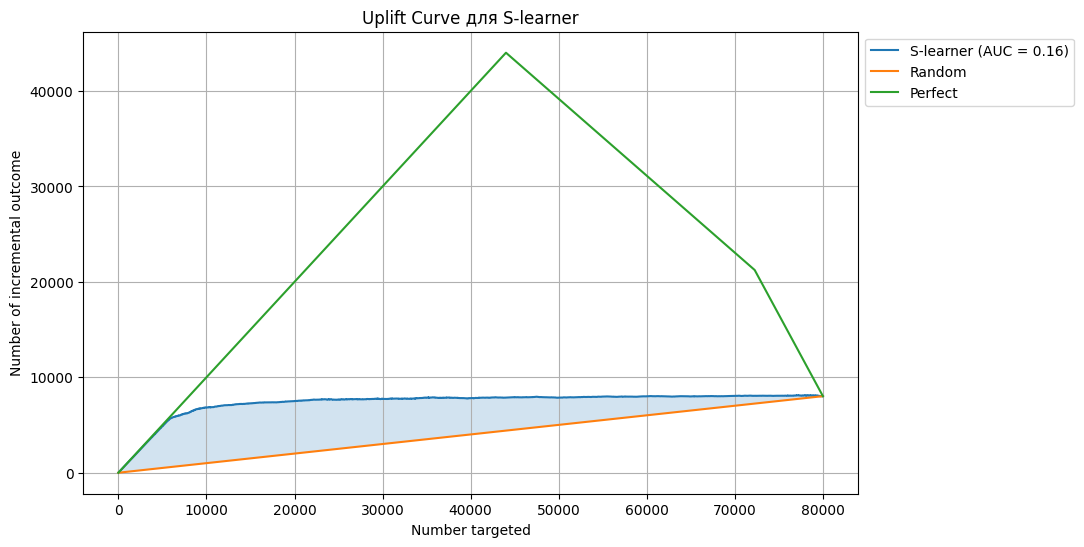

In [12]:
from sklift.viz import plot_uplift_curve
import matplotlib.pyplot as plt

# Построение Uplift curve
fig, ax = plt.subplots(figsize=(10, 6))
plot_uplift_curve(y_true=y_test.values,
                 uplift=uplift,
                 treatment=X_test['treatment'].values,
                 random=True,
                 name='S-learner',
                 ax=ax)

ax.set_title('Uplift Curve для S-learner')
ax.grid(True)
plt.show()

In [19]:
from sklift.metrics import qini_auc_score, uplift_auc_score

# Корректные метрики из библиотеки
qini_score = qini_auc_score(y_true=y_test.values,
                           uplift=uplift,
                           treatment=X_test['treatment'].values)

auuc_score = uplift_auc_score(y_true=y_test.values,
                             uplift=uplift,
                             treatment=X_test['treatment'].values)

print(f"Qini score: {qini_score:.3f} → 0.20")
print(f"AUUC score: {auuc_score:.3f} → 0.16")

Qini score: 0.196 → 0.20
AUUC score: 0.160 → 0.16


In [20]:
# Задание 6
# Вот пример, как обучить S-learner с помощью случайного леса из causalml. 

from causalml.inference.meta import BaseSClassifier
from sklearn.ensemble import RandomForestClassifier
from sklift.metrics import uplift_auc_score, qini_auc_score

learner = RandomForestClassifier(
    n_estimators=100,  
    max_depth=6,      
    random_state=42,  
    verbose=1         
)

# инициализация S-learner модели
s_learner = BaseSClassifier(
    learner=learner, # Базовая модель (в данном случае случайный лес)
    control_name=0,  # Значение признака treatment для контрольной группы
)

# обучаем S-learner
s_learner.fit(X_train.values, treatment=X_train['treatment'], y=y_train.values)


# удалим предыдущие прогнозы
X_test = X_test.drop(columns=['predicted_uplift'])

# получаем предсказания uplift для тестовой выборки
uplift_vals = s_learner.predict(np.array(X_test.values.copy())).squeeze()


# теперь можно оценить качество модели с помощью uplift-метрик
uplift_score = uplift_auc_score(y_test.values, uplift_vals, X_test['treatment'].values)
qini_score = qini_auc_score(y_test.values, uplift_vals, X_test['treatment'].values)

print(f"Uplift AUC: {uplift_score:.2f}")
print(f"Qini AUC: {qini_score:.2f}")



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   23.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   48.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Uplift AUC: 0.16
Qini AUC: 0.19


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [21]:
# Задание 7
# Загрузите данные, разделите выборку на тренировочную и тестовую в соотношении 80 на 20,
# стратифицируя выборки по столбцам treatment и conversion. Данные можно скачать здесь.

import pandas as pd
from sklearn.model_selection import train_test_split
# загрузите данные
data = pd.read_csv("yandex_plus.csv")

# разделим данные на признаки и целевую переменную
X = data.drop(['conversion'], axis=1)  
y = data['conversion']  

# применяем маппинг для удобства обучения модели
treatment_mapping = {
    'control': 0,  # 0 соответствует контрольной группе
    'treatment1': 1  # 1 соответствует группе воздействия
}

X['treatment'] = X['treatment'].map(treatment_mapping)

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=data[['conversion', 'treatment']],
                                    random_state=42)

In [22]:
# Задание 8
# Теперь обучите S-learner, используя библиотеку causalml 
# или базовые алгоритмы (RandomForestClassifier, CatBoostClassifier,LogisticRegression, UpliftRandomForestClassifier, XGBClassifier). 
# После обучения получите предсказания для тестовой выборки, 
# рассчитайте uplift для каждого пользователя как разницу между вероятностями отклика при наличии и 
# отсутствии воздействия (treatment=1 и treatment=0). 
# Не забудьте зафиксировать random_state=42 для воспроизводимости.
# Ваша задача — получить метрику Uplift score не меньше 0.19.

from sklearn.ensemble import RandomForestClassifier
from causalml.inference.meta import BaseSClassifier
from sklift.metrics import uplift_auc_score, qini_auc_score

learner = RandomForestClassifier(
    n_estimators=200,  
    max_depth=8,      
    random_state=42,  
    verbose=1     
)

# инициализируем S-learner с базовой моделью случайного леса
s_learner = BaseSClassifier(
    learner=learner,
    control_name = 0,
)

# обучаем S-learner
s_learner.fit(X_train.values, treatment=X_train['treatment'].values, y=y_train.values)

uplift_vals = s_learner.predict(X_test)

# теперь можно оценить качество модели с помощью uplift-метрик
# Оценка метрик uplift
uplift_score = uplift_auc_score(
    y_test.values,
    uplift_vals.squeeze(), 
    X_test['treatment'].values
)
qini_score = qini_auc_score(
    y_test.values,
    uplift_vals.squeeze(), 
    X_test['treatment'].values
)

print(f"Uplift AUC: {uplift_score:.2f}")
print(f"Qini AUC: {qini_score:.2f}")


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


Uplift AUC: 0.19
Qini AUC: 0.08


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [23]:
# Задание 9
# На полученных предсказаниях модели выберите топ-10% процентов пользователей по значению uplift. 
# Выведите среднее значение uplift. Предсказания уже получены и хранятся в переменнной uplift_vals.

top_n = 10

# возьмите топ-10% пользователей по uplift
top_uplift = np.percentile(uplift_vals, 100 - top_n)

# выведите среднее значение uplift
print(f"Среднее значение uplift для топ {top_n}% пользователей: {np.mean(uplift_vals[uplift_vals >= top_uplift]):.2f}")


Среднее значение uplift для топ 10% пользователей: 0.08
